#**Financial Fraudulent Transaction Detection Using Machine Learning Techniques**

**Imports Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

##**Data download and loading**

In [2]:
!gdown --id 1A_EE7CIltvI5YfP_EPzmQ5jeNezT7cfF

Downloading...
From: https://drive.google.com/uc?id=1A_EE7CIltvI5YfP_EPzmQ5jeNezT7cfF
To: /content/transactions.csv
100% 16.1M/16.1M [00:00<00:00, 60.8MB/s]


In [3]:
df = pd.read_csv("/content/transactions.csv")
new_df = df.drop(df.columns[0], axis=1)
new_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
199995,13,CASH_IN,149024.27,C1446913085,8688.0,157712.27,C476402209,440028.59,321427.51,0
199996,13,PAYMENT,71076.01,C1421983410,50291.0,0.00,M855368711,0.00,0.00,0
199997,13,CASH_OUT,147125.05,C80624764,0.0,0.00,C747330421,1058502.64,1325544.47,0
199998,13,CASH_OUT,97529.67,C595001108,0.0,0.00,C575555170,1921846.97,2019376.64,0


####**Findings: The shape of the dataframe is 199999 records and 10 features.**

In [4]:
new_df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [5]:
nulls = new_df.isnull().sum(axis=0).sort_values(ascending=False);
nulls

isFraud           0
newbalanceDest    0
oldbalanceDest    0
nameDest          0
newbalanceOrig    0
oldbalanceOrg     0
nameOrig          0
amount            0
type              0
step              0
dtype: int64

####Findings: From above data it can be seen that there is no null values at all in all the columns.

####**Discrpitive Statistics of the data set**

In [6]:
new_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,200000.00000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000
mean,10.06589,1.808112e+05,8.821957e+05,9.001938e+05,9.411592e+05,1.191866e+06,0.000735
std,2.12174,3.291800e+05,2.766264e+06,2.803759e+06,2.373010e+06,2.655236e+06,0.027101
min,1.00000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,9.00000,1.201612e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,10.00000,6.872104e+04,1.951000e+04,0.000000e+00,5.055850e+04,1.320839e+05,0.000000
75%,12.00000,2.290791e+05,1.915686e+05,2.275212e+05,7.645361e+05,1.189164e+06,0.000000
max,13.00000,1.000000e+07,3.893942e+07,3.894623e+07,3.903958e+07,3.904248e+07,1.000000


##**Data pre-processing and Exploratory Data Analysis**

##**Data imbalance**
###**The ratio of fraudulent / non-fraudulent transactions**

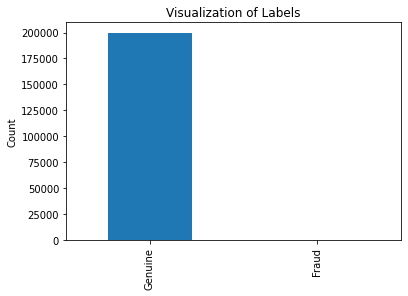

0    199853
1       147
Name: isFraud, dtype: int64

In [7]:
labels = ["Genuine", "Fraud"]
new_df["isFraud"].value_counts().plot(kind="bar")

plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()
new_df["isFraud"].value_counts()

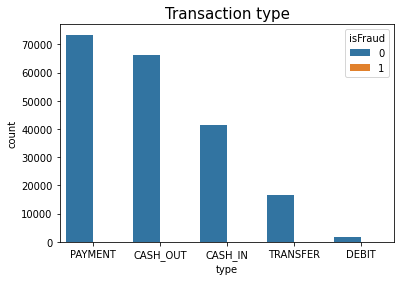

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.countplot(x='type', hue="isFraud", data=new_df, order=new_df['type'].value_counts().index)
ax.set_title("Transaction type", fontsize=15)
plt.show()


In [9]:
print('Proportion of fraudulent trades: {:.2f}%'.format(new_df['isFraud'].value_counts()[1]/new_df['isFraud'].size * 100))

Proportion of fraudulent trades: 0.07%


###**Applying the SMOTE(sampling methods) to balance the dataset classes.**

####**Under-sampling method**

In [10]:
fraud_count = len(new_df[new_df['isFraud'] == 1])
non_frauds_count = len(new_df[new_df['isFraud'] == 0])

sampled_non_fraud = new_df[new_df['isFraud'] == 0].sample(n=fraud_count)
sampled_non_fraud.reset_index(drop=True, inplace=True)

fraud = new_df[new_df['isFraud'] == 1]
fraud.reset_index(drop=True, inplace=True)


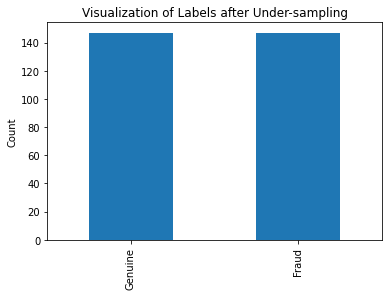

In [11]:
balanced_df = pd.concat([sampled_non_fraud, fraud]).reset_index(drop=True);
labels = ["Genuine", "Fraud"]

balanced_df['isFraud'].value_counts().plot(kind='bar')
plt.title("Visualization of Labels after Under-sampling")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [12]:
balanced_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,9,CASH_OUT,285087.30,C1427346769,0.00,0.00,C426784026,338644.86,1674917.08,0
1,11,TRANSFER,581810.04,C1531157872,0.00,0.00,C623476050,9991226.46,10749273.16,0
2,9,PAYMENT,25729.17,C1382712720,5065.58,0.00,M1928073278,0.00,0.00,0
3,9,PAYMENT,17663.67,C1471255996,1839626.39,1821962.72,M963562853,0.00,0.00,0
4,10,TRANSFER,524201.64,C534690797,0.00,0.00,C705487682,1770938.59,3631062.50,0
...,...,...,...,...,...,...,...,...,...,...
289,13,CASH_OUT,408.00,C1894004688,408.00,0.00,C1293978242,898297.85,1075854.14,1
290,13,TRANSFER,48375.02,C920803432,48375.02,0.00,C1767389067,0.00,0.00,1
291,13,CASH_OUT,48375.02,C1894578299,48375.02,0.00,C590035788,374803.26,658520.33,1
292,13,TRANSFER,4022667.54,C735463888,4022667.54,0.00,C1548348754,0.00,0.00,1


###**Feature Correlation**

By creating correlation maps we can identify features that are closely correlated with the legitimacy of our transactions. This can be a crucial step when performing dimensionality reduction, remoing/adding features

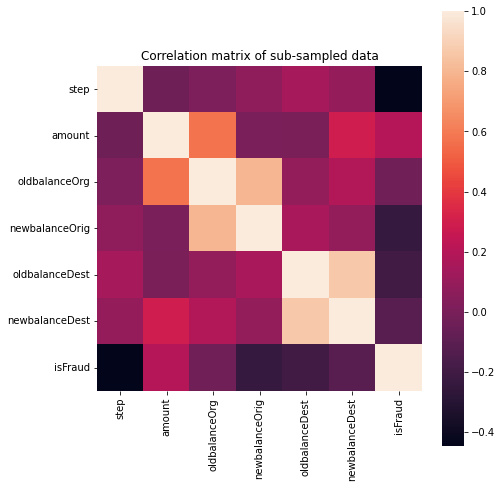

In [13]:
corr_matrix = balanced_df.corr()
f, ax = plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Correlation matrix of sub-sampled data')
sns.heatmap(corr_matrix, vmax=1, square=True)

In [14]:
corr_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,-0.040480,0.014725,0.075913,0.148153,0.094852,-0.445518
amount,-0.040480,1.000000,0.576313,0.002084,0.010957,0.293710,0.199727
oldbalanceOrg,0.014725,0.576313,1.000000,0.801800,0.090772,0.189274,-0.032854
newbalanceOrig,0.075913,0.002084,0.801800,1.000000,0.157375,0.087483,-0.238287
oldbalanceDest,0.148153,0.010957,0.090772,0.157375,1.000000,0.867495,-0.192417
newbalanceDest,0.094852,0.293710,0.189274,0.087483,0.867495,1.000000,-0.117992
isFraud,-0.445518,0.199727,-0.032854,-0.238287,-0.192417,-0.117992,1.000000


###**pair plots for all fields of the dataset.**

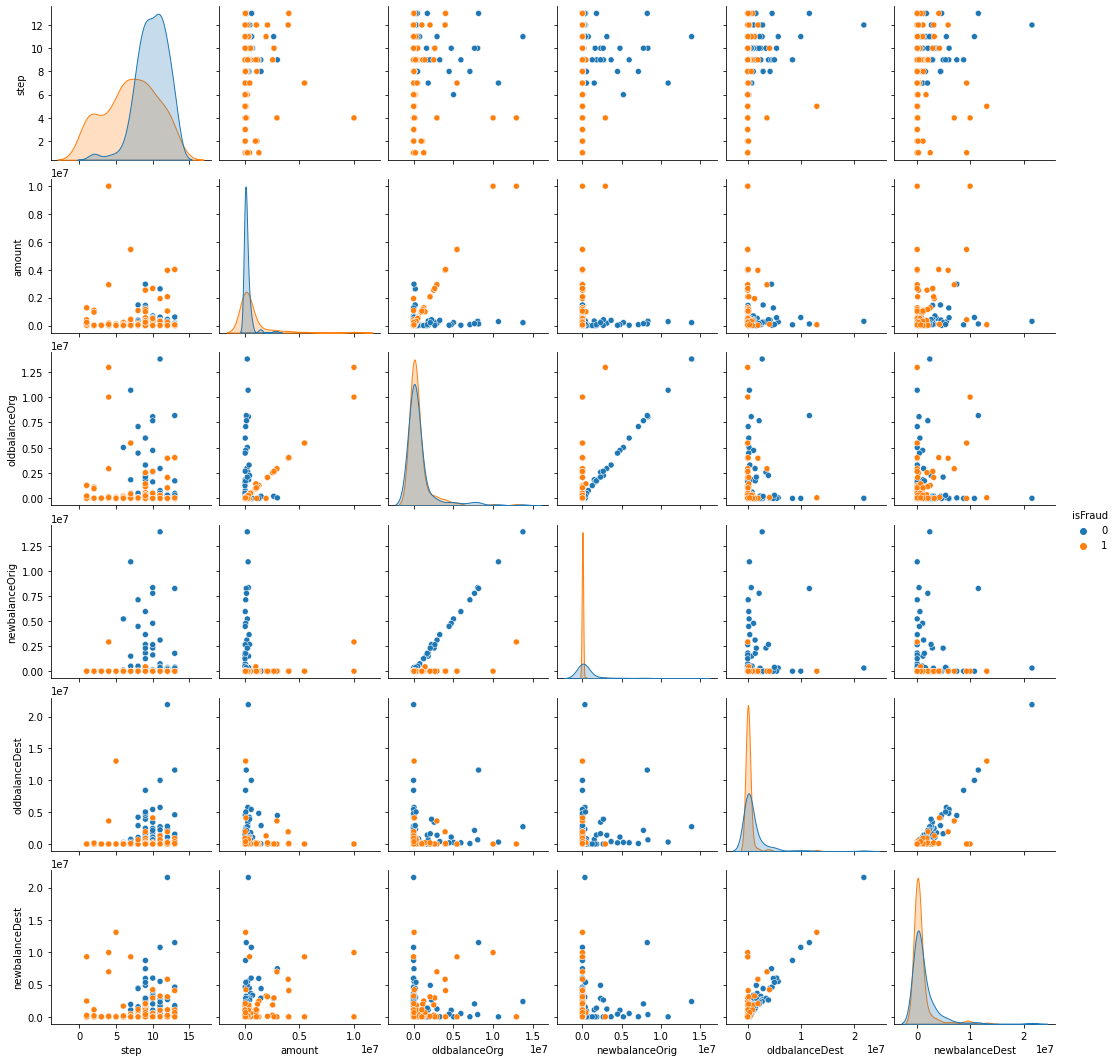

In [15]:
sns.pairplot(balanced_df, hue="isFraud")

####**Findings: The "newbalanceOrig" field is useful for classifying the fraudulent/non-fraudulent data. It can be notice from the above data that there is 145 fraudulent transaction when the balance is 0.00 and 83 non-fraudulent transaction when balance is 0.00. However, after some some balance we can see all transaction is almost non-fraudulent.So, I believe the "newbalanceOrig" can be the best feature to classifies the fraud/non-fraud transaction.**

###**New database for classification, by using the existing fields of the dataset.**

In [16]:
balanced_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,9,CASH_OUT,285087.30,C1427346769,0.00,0.00,C426784026,338644.86,1674917.08,0
1,11,TRANSFER,581810.04,C1531157872,0.00,0.00,C623476050,9991226.46,10749273.16,0
2,9,PAYMENT,25729.17,C1382712720,5065.58,0.00,M1928073278,0.00,0.00,0
3,9,PAYMENT,17663.67,C1471255996,1839626.39,1821962.72,M963562853,0.00,0.00,0
4,10,TRANSFER,524201.64,C534690797,0.00,0.00,C705487682,1770938.59,3631062.50,0
...,...,...,...,...,...,...,...,...,...,...
289,13,CASH_OUT,408.00,C1894004688,408.00,0.00,C1293978242,898297.85,1075854.14,1
290,13,TRANSFER,48375.02,C920803432,48375.02,0.00,C1767389067,0.00,0.00,1
291,13,CASH_OUT,48375.02,C1894578299,48375.02,0.00,C590035788,374803.26,658520.33,1
292,13,TRANSFER,4022667.54,C735463888,4022667.54,0.00,C1548348754,0.00,0.00,1


In [17]:
new_df["nameDest"].unique()

array(['M1979787155', 'M2044282225', 'C553264065', ..., 'C1587454679',
       'M855368711', 'C1091477477'], dtype=object)

In [18]:
features = balanced_df.copy(deep=True)
features['nameorig'] = features['nameOrig'].str.contains('C')
features['namedest'] = features['nameDest'].str.contains('C')

In [19]:
features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameorig,namedest
0,9,CASH_OUT,285087.30,C1427346769,0.00,0.00,C426784026,338644.86,1674917.08,0,True,True
1,11,TRANSFER,581810.04,C1531157872,0.00,0.00,C623476050,9991226.46,10749273.16,0,True,True
2,9,PAYMENT,25729.17,C1382712720,5065.58,0.00,M1928073278,0.00,0.00,0,True,False
3,9,PAYMENT,17663.67,C1471255996,1839626.39,1821962.72,M963562853,0.00,0.00,0,True,False
4,10,TRANSFER,524201.64,C534690797,0.00,0.00,C705487682,1770938.59,3631062.50,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
289,13,CASH_OUT,408.00,C1894004688,408.00,0.00,C1293978242,898297.85,1075854.14,1,True,True
290,13,TRANSFER,48375.02,C920803432,48375.02,0.00,C1767389067,0.00,0.00,1,True,True
291,13,CASH_OUT,48375.02,C1894578299,48375.02,0.00,C590035788,374803.26,658520.33,1,True,True
292,13,TRANSFER,4022667.54,C735463888,4022667.54,0.00,C1548348754,0.00,0.00,1,True,True


In [20]:
features['hasDest'] = ~features['nameorig'].isnull()

In [21]:
new_df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [22]:
features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameorig,namedest,hasDest
0,9,CASH_OUT,285087.30,C1427346769,0.00,0.00,C426784026,338644.86,1674917.08,0,True,True,True
1,11,TRANSFER,581810.04,C1531157872,0.00,0.00,C623476050,9991226.46,10749273.16,0,True,True,True
2,9,PAYMENT,25729.17,C1382712720,5065.58,0.00,M1928073278,0.00,0.00,0,True,False,True
3,9,PAYMENT,17663.67,C1471255996,1839626.39,1821962.72,M963562853,0.00,0.00,0,True,False,True
4,10,TRANSFER,524201.64,C534690797,0.00,0.00,C705487682,1770938.59,3631062.50,0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,13,CASH_OUT,408.00,C1894004688,408.00,0.00,C1293978242,898297.85,1075854.14,1,True,True,True
290,13,TRANSFER,48375.02,C920803432,48375.02,0.00,C1767389067,0.00,0.00,1,True,True,True
291,13,CASH_OUT,48375.02,C1894578299,48375.02,0.00,C590035788,374803.26,658520.33,1,True,True,True
292,13,TRANSFER,4022667.54,C735463888,4022667.54,0.00,C1548348754,0.00,0.00,1,True,True,True


###**Encoding the categorical attributes of the dataset using one-hot encoding.**

In [23]:
features = features.drop(columns=['nameOrig', 'nameDest'])
features

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,nameorig,namedest,hasDest
0,9,CASH_OUT,285087.30,0.00,0.00,338644.86,1674917.08,0,True,True,True
1,11,TRANSFER,581810.04,0.00,0.00,9991226.46,10749273.16,0,True,True,True
2,9,PAYMENT,25729.17,5065.58,0.00,0.00,0.00,0,True,False,True
3,9,PAYMENT,17663.67,1839626.39,1821962.72,0.00,0.00,0,True,False,True
4,10,TRANSFER,524201.64,0.00,0.00,1770938.59,3631062.50,0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
289,13,CASH_OUT,408.00,408.00,0.00,898297.85,1075854.14,1,True,True,True
290,13,TRANSFER,48375.02,48375.02,0.00,0.00,0.00,1,True,True,True
291,13,CASH_OUT,48375.02,48375.02,0.00,374803.26,658520.33,1,True,True,True
292,13,TRANSFER,4022667.54,4022667.54,0.00,0.00,0.00,1,True,True,True


In [24]:
categorical_dict = {
    "step": "category",
    "nameorig": "category",
    "namedest": "category",
    "hasDest": "category",
    "type": "category"
}

features = features.astype(categorical_dict)

for col in categorical_dict.keys():
  features = features.join(pd.get_dummies(features[[col]], prefix=col)).drop([col], axis=1)

features.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11,step_12,step_13,nameorig_True,namedest_False,namedest_True,hasDest_True,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,285087.30,0.00,0.00,338644.86,1674917.08,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0
1,581810.04,0.00,0.00,9991226.46,10749273.16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1
2,25729.17,5065.58,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0
3,17663.67,1839626.39,1821962.72,0.00,0.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0
4,524201.64,0.00,0.00,1770938.59,3631062.50,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1


##**Data Modeling**

We will first split the data into training and test sets, with a 70/30 split.

In [25]:
y = features["isFraud"]
X = features.drop(columns=["isFraud"])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(205, 27)
(205,)
(89, 27)
(89,)


###**Function to print the classification report for each model**

In [27]:
def metrics(actuals, predictions):
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))

## **1.Decision Tree modelling**

Evaluation of Decision Tree 

Accuracy: 0.95506
Precision: 0.97826
Recall: 0.93750
F1-score: 0.95745


Text(0.5, 15.0, 'Predicted Label')

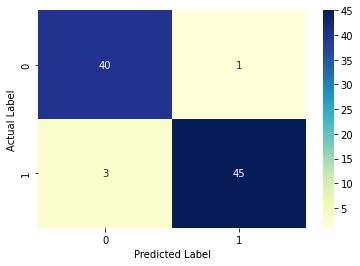

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Evaluation of Decision Tree ')
print()
metrics(y_test, y_pred.round())
dt_f1_score = f1_score(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

##**2.Random Forest**

Evaluation of Random Forest Model 

Accuracy: 0.88764
Precision: 0.95238
Recall: 0.83333
F1-score: 0.88889


Text(0.5, 15.0, 'Predicted Label')

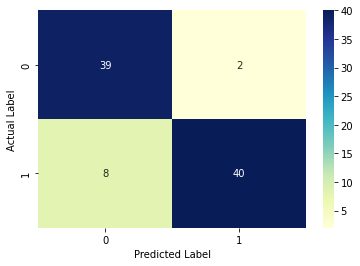

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_cnf_matrix = confusion_matrix(y_test, y_pred)
print('Evaluation of Random Forest Model ')
print()
metrics(y_test, y_pred.round())
rf_f1_score = f1_score(y_test, y_pred)
sns.heatmap(pd.DataFrame(rf_cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

##**3.Logistic Regression**

Evaluation of Logistic Regression Model After SMOT

Accuracy: 0.91011
Precision: 0.93478
Recall: 0.89583
F1-score: 0.91489


Text(0.5, 15.0, 'Predicted Label')

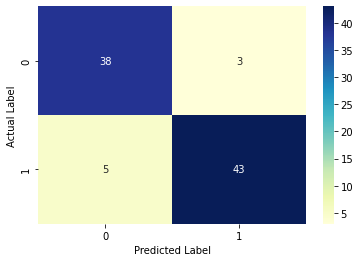

In [30]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_cnf_matrix = confusion_matrix(y_test, y_pred)
print('Evaluation of Logistic Regression Model After SMOT')
print()
metrics(y_test, y_pred.round())
logreg_f1_score = f1_score(y_test, y_pred)
sns.heatmap(pd.DataFrame(logreg_cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

## **4.SVM classifier using SVC class**

#### **Feature Scaling before applying it to SVM Classifier**

In [31]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Evaluation of SVM classifier Model 

Accuracy: 0.69663
Precision: 0.83871
Recall: 0.54167
F1-score: 0.65823


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Text(0.5, 15.0, 'Predicted Label')

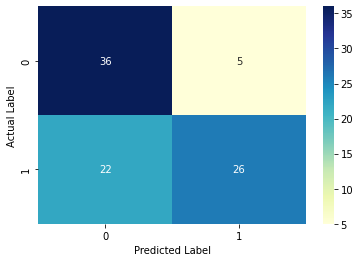

In [32]:
svm = SVC(kernel= 'linear', random_state=1)
svm.fit(X_train_std, y_train)
y_pred = rf.predict(X_test_std)
svm_cnf_matrix = confusion_matrix(y_test, y_pred)
print('Evaluation of SVM classifier Model ')
print()
metrics(y_test, y_pred.round())
svm_f1_score = f1_score(y_test, y_pred)
sns.heatmap(pd.DataFrame(svm_cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

##**5.Neural Network**

In [33]:
n_inputs = X_train.shape[1]

In [34]:
model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')])
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1/1 - 1s - loss: 256323.2656 - accuracy: 0.4512 - val_loss: 295912.3438 - val_accuracy: 0.3171 - 949ms/epoch - 949ms/step
Epoch 2/20
1/1 - 0s - loss: 230729.9062 - accuracy: 0.4085 - val_loss: 267785.4375 - val_accuracy: 0.2927 - 29ms/epoch - 29ms/step
Epoch 3/20
1/1 - 0s - loss: 207972.9531 - accuracy: 0.3963 - val_loss: 241997.4844 - val_accuracy: 0.3171 - 45ms/epoch - 45ms/step
Epoch 4/20
1/1 - 0s - loss: 185449.8125 - accuracy: 0.3963 - val_loss: 217087.8125 - val_accuracy: 0.3659 - 31ms/epoch - 31ms/step
Epoch 5/20
1/1 - 0s - loss: 164231.3438 - accuracy: 0.3963 - val_loss: 196868.8594 - val_accuracy: 0.4878 - 26ms/epoch - 26ms/step
Epoch 6/20
1/1 - 0s - loss: 145495.3750 - accuracy: 0.4390 - val_loss: 185145.5000 - val_accuracy: 0.4878 - 23ms/epoch - 23ms/step
Epoch 7/20
1/1 - 0s - loss: 135583.5781 - accuracy: 0.4512 - val_loss: 172853.7031 - val_accuracy: 0.4878 - 26ms/epoch - 26ms/step
Epoch 8/20
1/1 - 0s - loss: 126867.7344 - accuracy: 0.4451 - val_loss: 159460.546

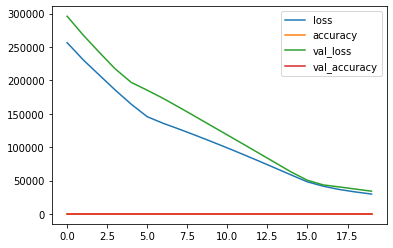

In [35]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [36]:
score = model.evaluate(X_test, y_test)
print(score)

3/3 [==============================] - 0s 4ms/step - loss: 46542.6914 - accuracy: 0.6067
[46542.69140625, 0.6067415475845337]


Evaluation of Neural Network Model

Accuracy: 0.60674
Precision: 0.67568
Recall: 0.52083
F1-score: 0.58824


Text(0.5, 15.0, 'Predicted Label')

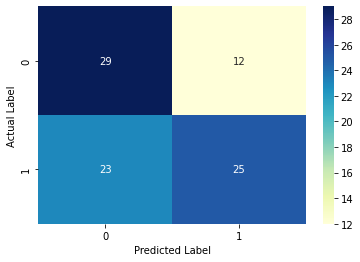

In [37]:
y_pred= np.argmax(model.predict(X_test), axis=-1) 
print('Evaluation of Neural Network Model')
print()
metrics(y_test, y_pred.round())
nn_f1_score = f1_score(y_test, y_pred)
nn_cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(nn_cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

###**Comparision of All algorithms with its F1-score**s


In [38]:
results = pd.DataFrame({
    'Model': ['Decision Tree','Random Forest','Logistic Regression','SVM'
              , 'Neural Network'],
    'Score': [ dt_f1_score,
              rf_f1_score,logreg_f1_score,svm_f1_score,nn_f1_score]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(5)

,Model
Score,
0.957447,Decision Tree
0.914894,Logistic Regression
0.888889,Random Forest
0.658228,SVM
0.588235,Neural Network


No handles with labels found to put in legend.


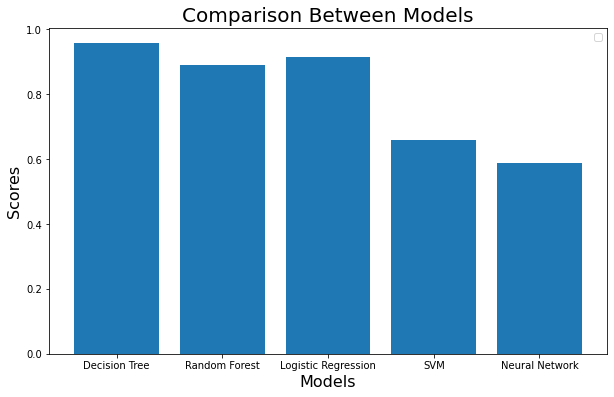

In [39]:
names = ['Decision Tree','Random Forest','Logistic Regression','SVM','Neural Network']
results = [dt_f1_score,rf_f1_score,logreg_f1_score,svm_f1_score,nn_f1_score]
plt.figure(figsize=(10,6))
plt.bar(names,results)
plt.xlabel("Models", fontsize=16) #seting the xtitle and size
plt.ylabel("Scores", fontsize=16) # Seting the ytitle and size
plt.title("Comparison Between Models", fontsize=20)
plt.legend()
plt.show()